C:\Users\Jinkala Venkat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Jinkala Venkat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jinkala Venkat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Jinkala Venkat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak

Optimal Number of Clusters: 4
Davies-Bouldin Index: 1.0062113196642417

Cluster Analysis:
   Cluster  AvgTotalSpending  AvgOrderValue  AvgTransactionCount  AvgRecency  \
0        0       3792.015714     977.418147             3.904762  113.333333   
1        1       2376.338333     527.968794             4.559524   82.059524   
2        2       5587.837857     747.341628             7.553571   79.571429   
3        3       1070.562353     563.316716             1.764706  274.176471   

   CustomerCount  
0             42  
1             84  
2             56  
3             17  


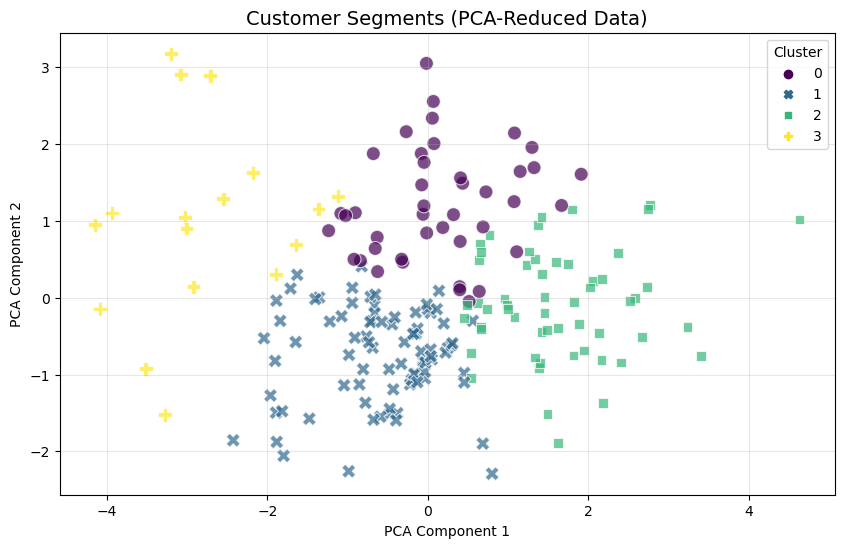

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers_path = 'C:/Users/Jinkala Venkat/Downloads/Customers.csv'
products_path = 'C:/Users/Jinkala Venkat/Downloads/Products.csv'
transactions_path = 'C:/Users/Jinkala Venkat/Downloads/Transactions.csv'

customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)
transactions_df = pd.read_csv(transactions_path)

# Merge datasets
transactions_products = transactions_df.merge(products_df, on='ProductID', how='left')
merged_data = transactions_products.merge(customers_df, on='CustomerID', how='left')

# Convert TransactionDate to datetime
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])

# Feature Engineering: Create customer-level metrics
customer_metrics = merged_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    AverageOrderValue=('TotalValue', 'mean'),
    TransactionCount=('TransactionID', 'nunique'),
    Recency=('TransactionDate', lambda x: (pd.Timestamp('now') - x.max()).days)
).reset_index()

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customer_metrics[['TotalSpending', 'AverageOrderValue', 'TransactionCount', 'Recency']])

# Perform clustering and evaluate DB Index
db_scores = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    db_index = davies_bouldin_score(normalized_data, cluster_labels)
    db_scores[n_clusters] = db_index

optimal_clusters = min(db_scores, key=db_scores.get)
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_metrics['Cluster'] = final_kmeans.fit_predict(normalized_data)

# Analyze clusters
cluster_analysis = customer_metrics.groupby('Cluster').agg(
    AvgTotalSpending=('TotalSpending', 'mean'),
    AvgOrderValue=('AverageOrderValue', 'mean'),
    AvgTransactionCount=('TransactionCount', 'mean'),
    AvgRecency=('Recency', 'mean'),
    CustomerCount=('CustomerID', 'count')
).reset_index()

# Print clustering results
print("Optimal Number of Clusters:", optimal_clusters)
print("Davies-Bouldin Index:", db_scores[optimal_clusters])
print("\nCluster Analysis:")
print(cluster_analysis)

# Reduce data to 2D for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
customer_metrics['PCA1'] = reduced_data[:, 0]
customer_metrics['PCA2'] = reduced_data[:, 1]

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Cluster', 
    data=customer_metrics, 
    palette='viridis', 
    style='Cluster', 
    s=100, alpha=0.7
)
plt.title('Customer Segments (PCA-Reduced Data)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', fontsize=10)
plt.grid(alpha=0.3)
plt.show()
